## Лабораторная работа №1 по системам обработки больших данных

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from functools import reduce
from pyspark.sql import functions 
from pyspark.sql.types import *
from pyspark.sql.functions import length, mean, split, udf, col
from pyspark.sql import functions as F
import pyarrow.parquet as pq
import seaborn as sns


MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab1") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

filename_data = 'data/china_082019_3_tweets_csv_hashed_part2.csv'
df = spark.read.csv(filename_data,header=True, mode="DROPMALFORMED", inferSchema=True)

In [2]:
print('Data frame type: ' + str(type(df)))
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>
Data overview
root
 |-- tweetid: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- user_display_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_reported_location: string (nullable = true)
 |-- user_profile_description: string (nullable = true)
 |-- user_profile_url: string (nullable = true)
 |-- follower_count: string (nullable = true)
 |-- following_count: string (nullable = true)
 |-- account_creation_date: string (nullable = true)
 |-- account_language: string (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- tweet_time: string (nullable = true)
 |-- tweet_client_name: string (nullable = true)
 |-- in_reply_to_userid: string (nullable = true)
 |-- in_reply_to_tweetid: string (nullable = true)
 |-- quoted_tweet_tweetid: string (nullable = true)
 |-- is_retweet: string (nullable = true)
 |-- retweet_userid: s

,Column Name,Data type
0,tweetid,string
1,userid,string
2,user_display_name,string
3,user_screen_name,string
4,user_reported_location,string
5,user_profile_description,string
6,user_profile_url,string
7,follower_count,string
8,following_count,string
9,account_creation_date,string


In [3]:
df = df.drop("user_profile_description", "account_creation_date", "user_reported_location", "account_language", "tweet_text", "tweet_time", "tweet_client_name", "in_reply_to_userid", "in_reply_to_tweetid", "quoted_tweet_tweetid", "retweet_userid", "retweet_tweetid", "latitude", "longitude", "user_mentions", "poll_choices", "hashtags", "urls", "user_screen_name", "user_display_name", "user_profile_url")

In [4]:
df = df.withColumn("tweetid", col("tweetid").cast(LongType()))
df = df.withColumn("userid", col("userid").cast(LongType()))
df = df.withColumn("follower_count", col("follower_count").cast(IntegerType()))
df = df.withColumn("following_count", col("following_count").cast(IntegerType()))
df = df.withColumn("tweet_language", col("tweet_language").cast(StringType()))
df = df.withColumn("quote_count", col("quote_count").cast(IntegerType()))
df = df.withColumn("reply_count", col("reply_count").cast(IntegerType()))
df = df.withColumn("like_count", col("like_count").cast(IntegerType()))
df = df.withColumn("retweet_count", col("retweet_count").cast(IntegerType()))
df = df.withColumn("is_retweet", col("is_retweet").cast("boolean"))
df = df.withColumn("is_like", F.when(df["like_count"] > 0, True).otherwise(False).cast("boolean"))
df = df.withColumn("is_en_language", F.when(df["tweet_language"] == "en", True).otherwise(False).cast("boolean"))
df = df.withColumn("is_popular", F.when(df["follower_count"] > 15000, True).otherwise(False).cast("boolean"))
df.show(10)

+------------------+--------+--------------+---------------+--------------+----------+-----------+-----------+----------+-------------+-------+--------------+----------+
|           tweetid|  userid|follower_count|following_count|tweet_language|is_retweet|quote_count|reply_count|like_count|retweet_count|is_like|is_en_language|is_popular|
+------------------+--------+--------------+---------------+--------------+----------+-----------+-----------+----------+-------------+-------+--------------+----------+
|728743925335363584|54107005|         62016|          63183|            en|     false|          0|          0|         0|            0|  false|          true|      true|
|706064477410697217|54107005|         62016|          63183|            en|     false|          0|          0|         0|            0|  false|          true|      true|
|801380140550914048|54107005|         62016|          63183|            en|     false|          0|          0|         0|            0|  false|       

In [5]:
string_columns = ['tweet_language', 'is_like', 'is_en_language', 'is_popular']
numeric_columns = ['tweetid','userid','follower_count','following_count','quote_count','reply_count','like_count', 'retweet_count']
binary_columns = ['is_retweet']

def view_missing_values(string_columns,numeric_columns,binary_columns):
    missing_values = {} 
    for index, column in enumerate(df.columns):
        if column in string_columns:    # check string columns with None and Null values
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
            missing_values.update({column:missing_count})
        if column in numeric_columns:  # check zeroes, None, NaN
            missing_count = df.where(col(column).isin([None,np.nan])).count()
            missing_values.update({column:missing_count})
        if column in binary_columns:  # check zeroes, None, NaN
            missing_count = df.where(col(column).isNull()).count()
            missing_values.update({column:missing_count})
    return pd.DataFrame.from_dict([missing_values])
missing_df = view_missing_values(string_columns,numeric_columns,binary_columns)
missing_df

,tweetid,userid,follower_count,following_count,tweet_language,is_retweet,quote_count,reply_count,like_count,retweet_count,is_like,is_en_language,is_popular
0,0,0,0,0,524653,1067143,0,0,0,0,0,0,0


In [6]:
df.printSchema()

root
 |-- tweetid: long (nullable = true)
 |-- userid: long (nullable = true)
 |-- follower_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- quote_count: integer (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- is_like: boolean (nullable = false)
 |-- is_en_language: boolean (nullable = false)
 |-- is_popular: boolean (nullable = false)



<Figure size 800x500 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1b73bcbd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1b73be790>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fe1b73bc050>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1b73bff10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1b73ccad0>],
 'means': []}

Text(0.5, 1.0, 'Boxplot of column follower_count')

Text(0.5, 0, 'Value')

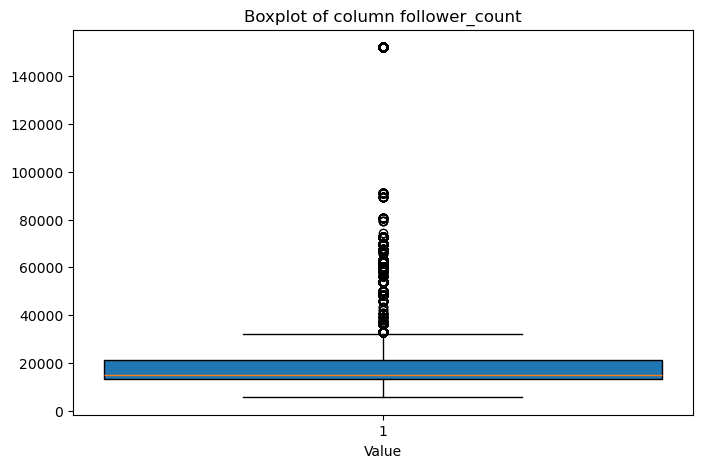

<Figure size 800x500 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1f84a4a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1f8340e90>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fe1b73f28d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1f8342710>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1f8343310>],
 'means': []}

Text(0.5, 1.0, 'Boxplot of column following_count')

Text(0.5, 0, 'Value')

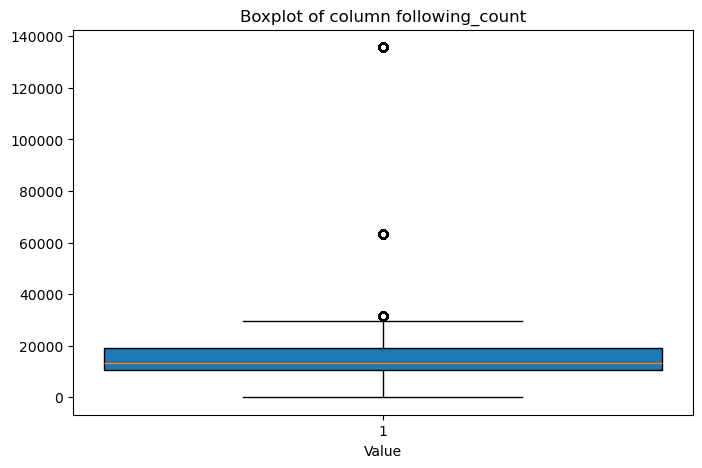

In [7]:
df = df.dropna()
num_col = ["follower_count", "following_count"]
for column in num_col:
    boxplot_data = df.select(column).collect()
    values = [row[column] for row in boxplot_data]
    plt.figure(figsize=(8, 5))
    plt.boxplot(values, widths=0.9, patch_artist=True, showmeans=False, autorange=True)
    plt.title(f'Boxplot of column {column}')
    plt.xlabel('Value')
    plt.show()
    



<Figure size 800x500 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe18bba2f50>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe18a9fc250>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fe18cf38690>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe18a9fd590>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe18a9fded0>],
 'means': []}

Text(0.5, 1.0, 'Boxplot of column follower_count')

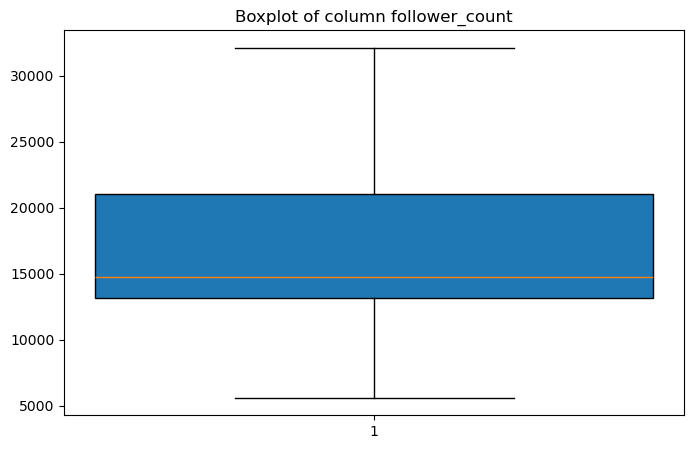

<Figure size 800x500 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1d5b495d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1d5b4aa50>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fe1e1fbf590>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe1d5b4bc50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1d49ac510>],
 'means': []}

Text(0.5, 1.0, 'Boxplot of column following_count')

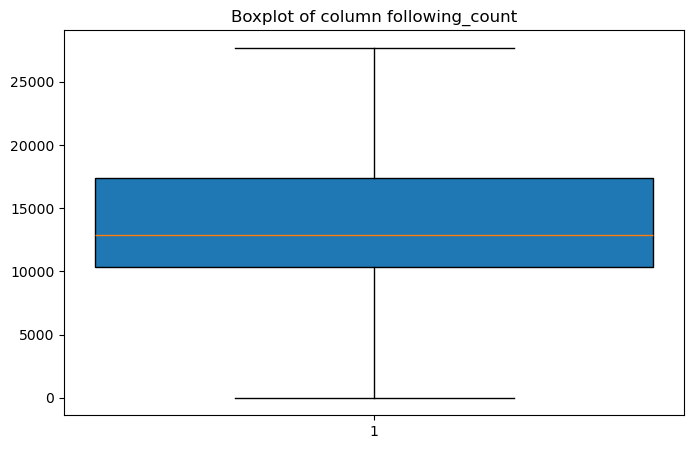

In [8]:
for column in num_col:

    quantiles = df.approxQuantile(column, [0.25, 0.75], 0)  # 25-й и 75-й процентили
    IQR = quantiles[1] - quantiles[0]
    lower_bound = quantiles[0] - 1.5 * IQR
    upper_bound = quantiles[1] + 1.5 * IQR
    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    boxplot_data = df.select(column).collect()
    values = [row[column] for row in boxplot_data]
    plt.figure(figsize=(8, 5))
    plt.boxplot(values, widths=0.9, patch_artist=True, showmeans=False, autorange=True)
    plt.title(f'Boxplot of column {column}')
    plt.show()
    

  


In [9]:
for col_name in num_col:
    quantiles = df.approxQuantile(col_name, [0.5], 0.05)
    median_score = quantiles[0]
    print(f'Median {col_name}: {median_score}\n')

df.select(num_col).describe().show()

Median follower_count: 14765.0

Median following_count: 12904.0

+-------+-----------------+------------------+
|summary|   follower_count|   following_count|
+-------+-----------------+------------------+
|  count|          3341921|           3341921|
|   mean| 16711.2241270814| 13334.29114153207|
| stddev|5268.465251906961|5297.2121590358065|
|    min|             5603|                 1|
|    max|            32107|             27690|
+-------+-----------------+------------------+



**count** - Количество строк\
**mean** - Среднее значение\
**stddev** - Стандартное отклонение\
**min** - Минимальное значение\
**max** - Максимальное значение

<Figure size 1200x1200 with 0 Axes>

<Axes: >

([<matplotlib.patches.Wedge at 0x7fe1e0ddb690>,
 [Text(1.029710698578093, 0.386905514607657, 'True'),
  Text(-1.0297106804657374, -0.38690556281189326, 'False')],
 [Text(0.5616603810425962, 0.21103937160417652, '11.4%'),
  Text(-0.5616603711631295, -0.21103939789739629, '88.6%')])

Text(0.5, 1.0, 'isRetweet Percentage')

<Axes: >

([<matplotlib.patches.Wedge at 0x7fe1ba766890>,
 [Text(1.0949064642607163, 0.10573473658215195, 'True'),
  Text(-1.094906466735616, -0.10573471095401624, 'False')],
 [Text(0.5972217077785724, 0.057673492681173784, '3.1%'),
  Text(-0.5972217091285178, -0.05767347870219067, '96.9%')])

Text(0.5, 1.0, 'isLike Percentage')

<Axes: >

([<matplotlib.patches.Wedge at 0x7fe1b5b346d0>,
 [Text(0.9499008130533056, 0.5546967147556123, 'True'),
  Text(-0.949900839020532, -0.5546966702875451, 'False')],
 [Text(0.5181277162108939, 0.3025618444121521, '16.8%'),
  Text(-0.5181277303748356, -0.30256182015684274, '83.2%')])

Text(0.5, 1.0, 'isEng Percentage')

<Axes: >

([<matplotlib.patches.Wedge at 0x7fe1db2ae890>,
 [Text(0.15058805168850095, 1.0896436292149199, 'True'),
  Text(-0.15058805168850056, -1.0896436292149199, 'False')],
 [Text(0.08213893728463686, 0.5943510704808653, '45.6%'),
  Text(-0.08213893728463667, -0.5943510704808653, '54.4%')])

Text(0.5, 1.0, 'isPopular Percentage')

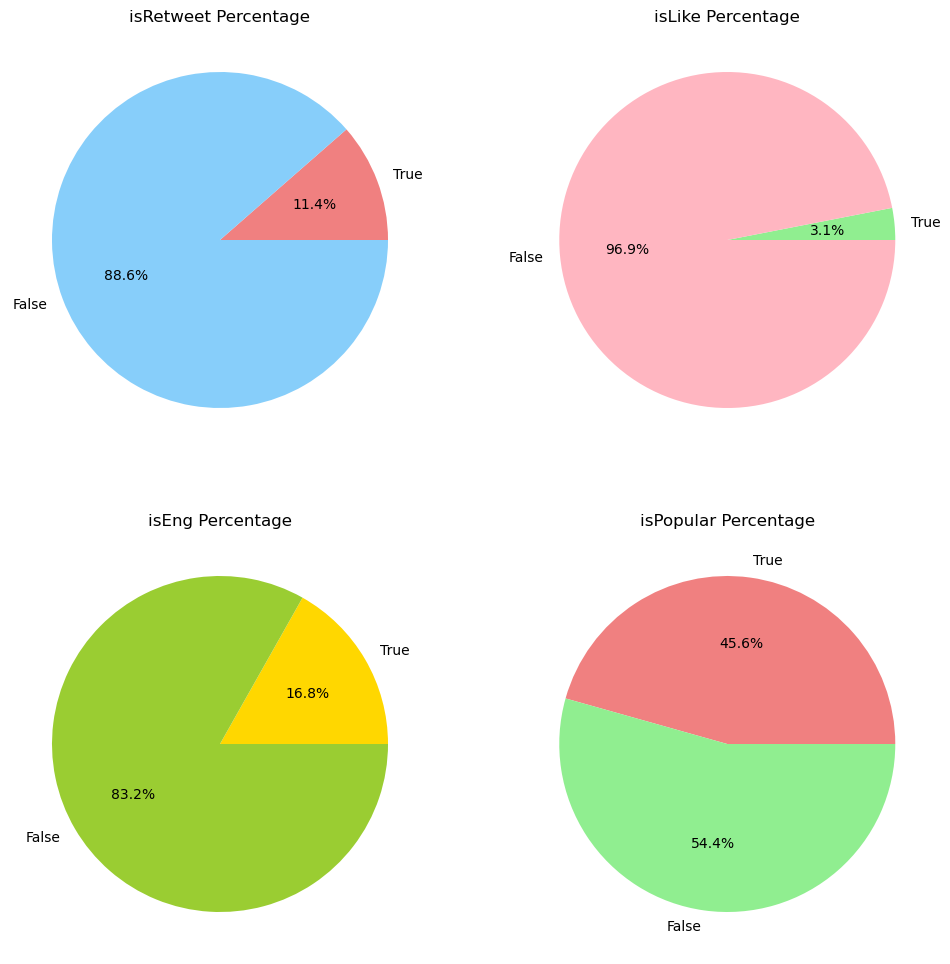

In [10]:
count_isretweet = df.groupBy("is_retweet").count().collect()
count_islike = df.groupBy("is_like").count().collect()
count_isenlang = df.groupBy("is_en_language").count().collect()
count_ispopular = df.groupBy("is_popular").count().collect()

values_isretweet = [x['count'] for x in count_isretweet]
categories_isretweet = [str(x['is_retweet']) for x in count_isretweet]

values_islike = [x['count'] for x in count_islike]
categories_islike = [str(x['is_like']) for x in count_islike]

values_isenlang = [x['count'] for x in count_isenlang]
categories_isenlang = [str(x['is_en_language']) for x in count_isenlang]

values_ispopular = [x['count'] for x in count_ispopular]
categories_ispopular = [str(x['is_popular']) for x in count_ispopular]

plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.pie(values_isretweet, labels=categories_isretweet, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('isRetweet Percentage')

plt.subplot(222)
plt.pie(values_islike, labels=categories_islike, autopct='%1.1f%%', colors=['lightgreen', 'lightpink'])
plt.title('isLike Percentage')

plt.subplot(223)
plt.pie(values_isenlang, labels=categories_isenlang, autopct='%1.1f%%', colors=['gold', 'yellowgreen'])
plt.title('isEng Percentage')

plt.subplot(224)
plt.pie(values_ispopular, labels=categories_ispopular, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('isPopular Percentage')

plt.show()

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
selected_data = df

assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
assembled_data = assembler.transform(selected_data)
correlation_matrix = Correlation.corr(assembled_data, "features").head()
corr_matrix = correlation_matrix[0].toArray()
correlation_df = spark.createDataFrame(corr_matrix, numeric_columns)
correlation_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             tweetid|              userid|      follower_count|     following_count|         quote_count|         reply_count|          like_count|       retweet_count|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|  0.3447706777593013| 0.03564400145871071|  0.2162246536877016|0.014482096884997783| -0.1079738259618912|-0.01391473240864...|-0.01708794670989833|
|  0.3447706777593013|                 1.0|0.031121184413142322| 0.20427194625224857|-0.00691737390520405|-0.17873385226630198|-0.00820699309780...|-0.00901041366803...|
| 0.03564400145871071|0.031121184413142322|                 1.0|   0.737001939319911|0.006390563383212371| 0.05337928240638143|-0.00236000528121...|1.

<Figure size 1100x800 with 0 Axes>

Text(0.5, 1.0, 'Correlation Heatmap')

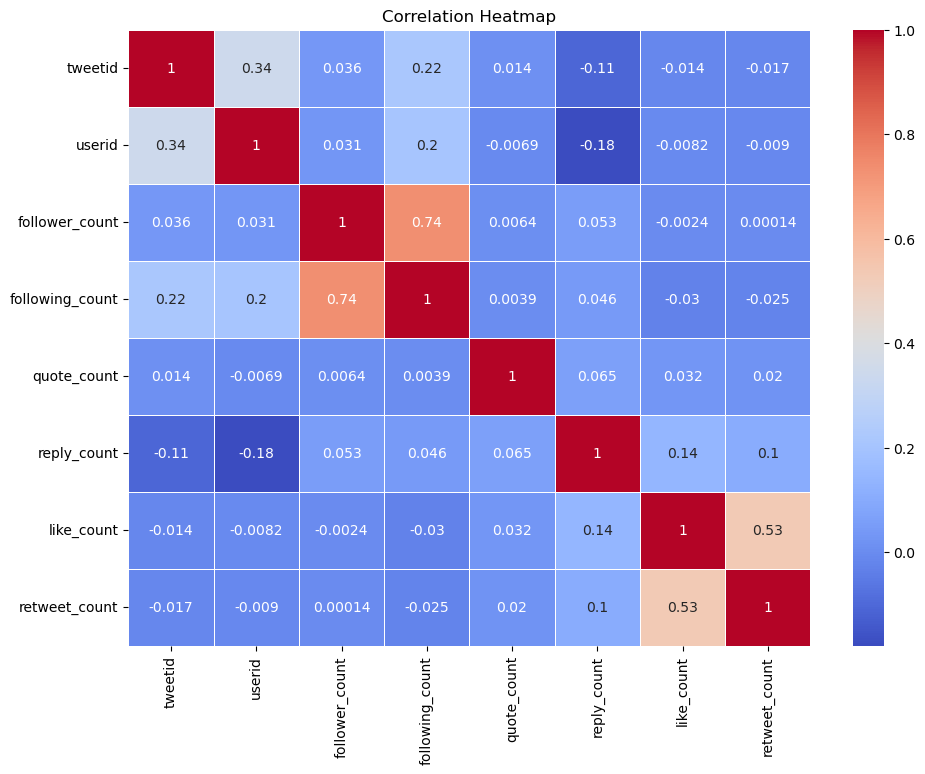

In [12]:
corr_matrix_pd = pd.DataFrame(corr_matrix, columns=numeric_columns, index=numeric_columns)

# Построение тепловой карты
plt.figure(figsize=(11, 8))
heatmap = sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
sample = df.sample(False, 0.1, seed=69)

followers = sample.select('follower_count').collect()
followings = sample.select('following_count').collect()
likes = sample.select('like_count').collect()
retweets = sample.select('retweet_count').collect()

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Following and followers')

Text(0.5, 0, 'Count followers')

Text(0, 0.5, 'Count followings')

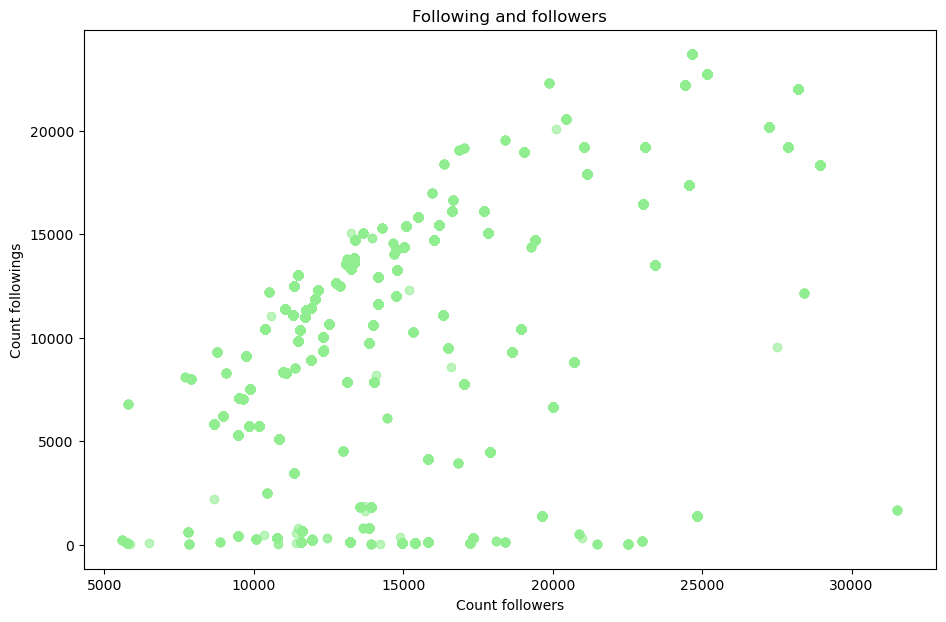

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Likes and retweets')

Text(0.5, 0, 'Count likes')

Text(0, 0.5, 'Count retweets')

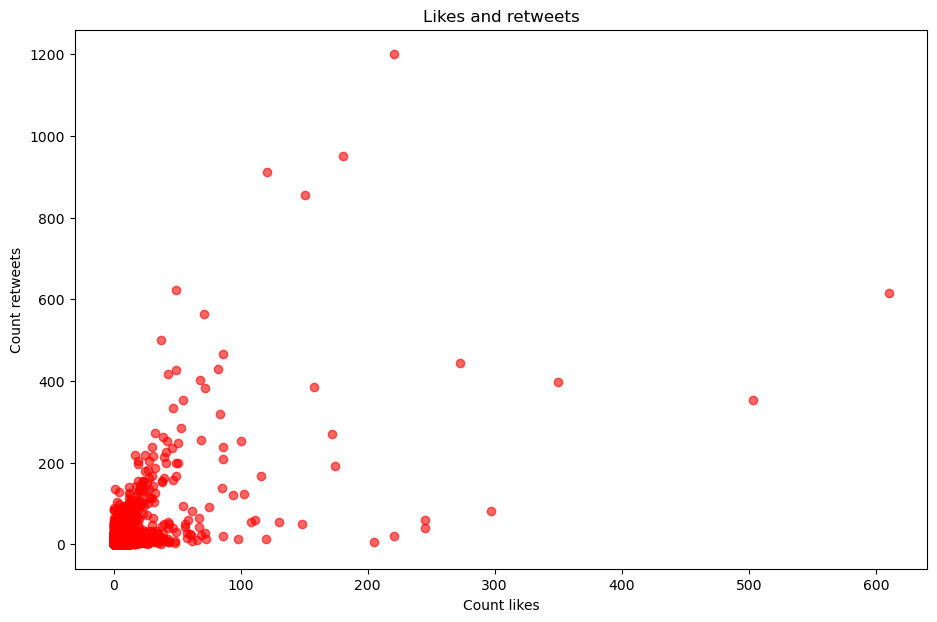

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Likes and followers')

Text(0.5, 0, 'Count followers')

Text(0, 0.5, 'Count likes')

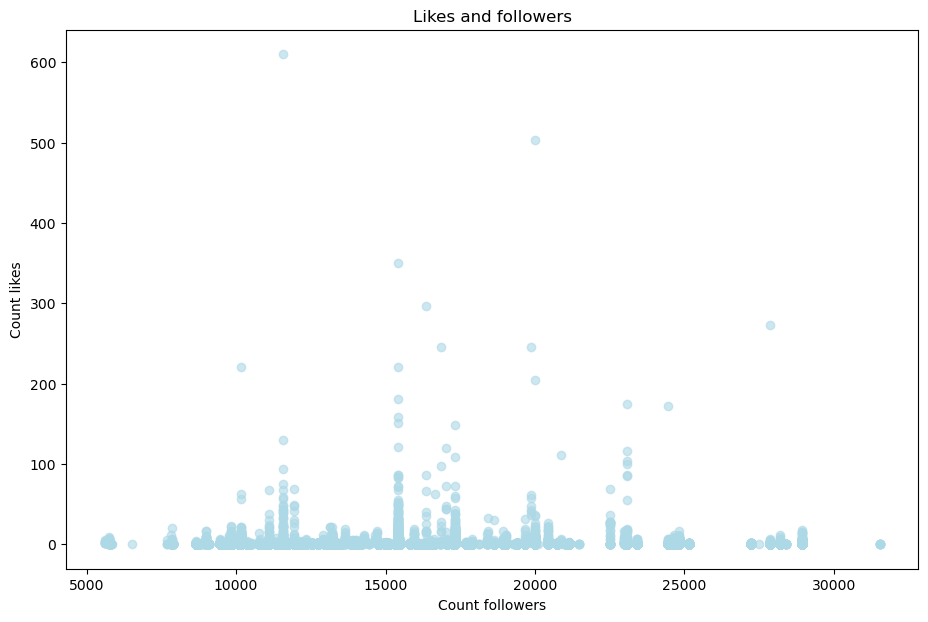

In [14]:
plt.figure(figsize=(11, 7))
plt.scatter([x['follower_count'] for x in followers], [x['following_count'] for x in followings], alpha=0.6, color='lightgreen')
plt.title('Following and followers')
plt.xlabel('Count followers')
plt.ylabel('Count followings')
plt.show()

plt.figure(figsize=(11, 7))
plt.scatter([x['like_count'] for x in likes], [x['retweet_count'] for x in retweets], alpha=0.6, color='red')
plt.title('Likes and retweets')
plt.xlabel('Count likes')
plt.ylabel('Count retweets')
plt.show()

plt.figure(figsize=(11, 7))
plt.scatter([x['follower_count'] for x in followers], [x['like_count'] for x in likes], alpha=0.6, color='lightblue')
plt.title('Likes and followers')
plt.xlabel('Count followers')
plt.ylabel('Count likes')
plt.show()



In [15]:
df.count()

3341921

In [16]:
df.write.mode('overwrite').parquet("data/df.parquet")